# Computational Methods for Finance
***

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import seaborn as sns
import pandas as pd
import mibian as mb
import numpy as np

***
## 1. Descriptive Analysis

In [2]:
ticker = 'BNB-USD'
start_date = '2022-03-27'
end_date = '2023-03-28'
interval = '1d'

crypto = yf.download(tickers = ticker,
                      start = start_date,
                      end = end_date,
                      interval = interval)

[*********************100%***********************]  1 of 1 completed


### 1.1 Data

In [3]:
crypto

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-27,415.931366,431.025574,412.382904,430.503265,430.503265,1499505093
2022-03-28,430.546814,440.728394,428.565216,430.390869,430.390869,2128699500
2022-03-29,430.074890,441.507538,430.074890,434.505676,434.505676,1987696098
2022-03-30,434.429718,448.947174,427.692078,442.684845,442.684845,2181737151
2022-03-31,442.658875,451.961090,424.950287,428.916107,428.916107,2632534284
...,...,...,...,...,...,...
2023-03-23,321.863525,331.968506,319.892212,329.837006,329.837006,547390925
2023-03-24,329.808075,330.173981,317.776794,322.359344,322.359344,468651735
2023-03-25,322.319855,325.002838,319.910919,322.673065,322.673065,439062620


In [4]:
crypto.shape

(366, 6)

In [5]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-03-27 to 2023-03-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       366 non-null    float64
 1   High       366 non-null    float64
 2   Low        366 non-null    float64
 3   Close      366 non-null    float64
 4   Adj Close  366 non-null    float64
 5   Volume     366 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


In [6]:
crypto.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,366.00,366.00,366.00,366.00,366.00,3.660000e+02
mean,299.54,306.27,292.30,299.25,299.25,1.120898e+09
std,50.72,51.63,50.12,50.36,50.36,6.695466e+08
min,196.96,216.08,184.54,197.04,197.04,2.761153e+08
25%,271.76,276.00,265.70,271.82,271.82,6.337325e+08
50%,291.32,298.62,285.85,291.30,291.30,9.835477e+08
75%,316.15,323.25,306.39,315.33,315.33,1.426590e+09
max,450.26,459.81,445.04,450.35,450.35,5.390604e+09


In [7]:
crypto['Adj Close'].idxmax()

Timestamp('2022-04-03 00:00:00')

In [8]:
crypto['Adj Close'].idxmin()

Timestamp('2022-06-18 00:00:00')

The dataset consists of daily BNB-USD price data from March 27, 2022, to March 27, 2023, with 366 rows and 6 columns. Each row represents one day's worth of price data, including open, high, low, close, adjusted close, and volume. Each value is a float except the volume, which is an integer.

<table>
  <tr>
      <th></th>
      <th>Date</th>
      <th>Price</th>
  </tr>
  <tr>
    <th>52 Wk L</th>
    <td>18 June 2022</td>
    <td>\$197.04</td>
  </tr>
  <tr>
    <th>52 Wk H</th>
    <td>3 April 2022</td>
    <td>\$450.35</td>
  </tr>
</table>

### 1.2 Visualisation

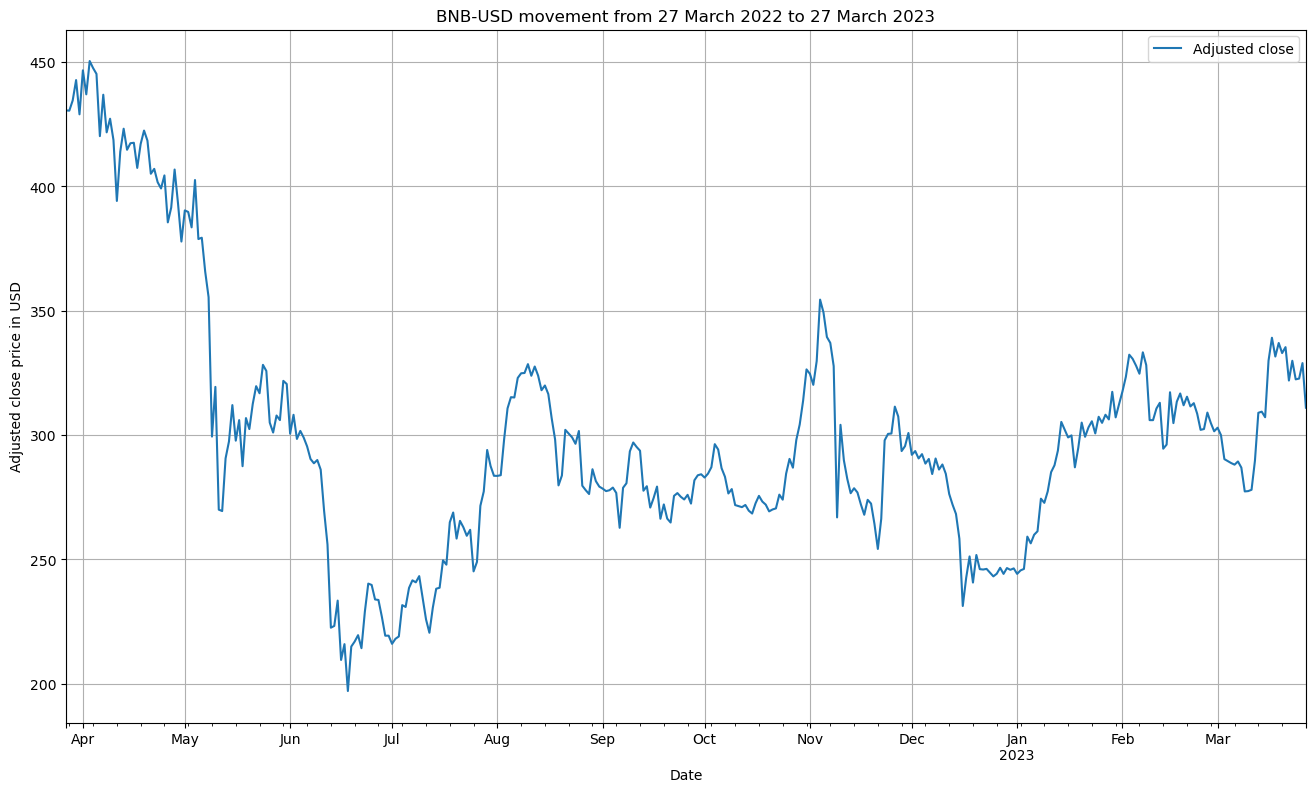

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
crypto['Adj Close'].plot(ax=ax, label="Adjusted close")

plt.title('BNB-USD movement from 27 March 2022 to 27 March 2023')
ax.set_ylabel('Adjusted close price in USD')
ax.set_xlabel('Date')

plt.legend()
plt.grid()
plt.show()

### 1.3 Annualised volatility

In [10]:
log_returns = np.log(crypto['Adj Close'] / crypto['Adj Close'].shift(1))

vol = np.sqrt(365) * log_returns[182:].std()

print('The annualised volatility based on the last 6-months for BNB is {:.2f}%.'.format((vol * 100)))

The annualised volatility based on the last 6-months for BNB is 61.50%.


***
## 2. Methodology

### 2.1 European call with Binomial tree

In [11]:
S0 = 310.84       # spot stock price
K = 345           # strike
T = 1/4           # maturity (3 months)
r = 0.0353        # risk free rate
sig = vol.round(4)# volatility
N = 6             # Number of time steps for binomial tree

In [12]:
# each time step of length is dt
dt = T / N

# the stock moves up in increments of u
u = np.exp(sig * np.sqrt(dt))

# the stock moves down in increments of d
d = 1 / u

print('dt:', round(dt, 4))
print('u:', round(u, 4))
print('d:', round(d, 4))

dt: 0.0417
u: 1.1338
d: 0.882


In [13]:
# tree construction

S_tree = np.zeros((N + 1, N + 1))
S_tree[0, 0] = S0 # tree starts with spot stock price
z = 1

for t in range(1, N + 1):
    for i in range(z):
        S_tree[i, t] = S_tree[i, t-1] * u # up movement
        S_tree[i+1, t] = S_tree[i, t-1] * d # down movement
    z += 1

S_tree

array([[310.84      , 352.416833  , 399.55483265, 452.99784047,
        513.58919152, 582.28502232, 660.16935873],
       [  0.        , 274.1682478 , 310.84      , 352.416833  ,
        399.55483265, 452.99784047, 513.58919152],
       [  0.        ,   0.        , 241.82289314, 274.1682478 ,
        310.84      , 352.416833  , 399.55483265],
       [  0.        ,   0.        ,   0.        , 213.29352365,
        241.82289314, 274.1682478 , 310.84      ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        188.12994353, 213.29352365, 241.82289314],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 165.93506942, 188.12994353],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , 146.35866437]])

In [14]:
a = np.exp(r * dt)    

# each probability of an up move is p
p = (a - d)/ (u - d)  

# each probability of an down move is p
q = 1.0 - p           

print('risk free compound return:', round(a, 4))
print('risk neutral up probability:', round(p, 4))
print('risk neutral down probability:', round(q, 4))

risk free compound return: 1.0015
risk neutral up probability: 0.4745
risk neutral down probability: 0.5255


In [15]:
def binomial_tree(S, K, N, payoff):
    
    V = np.zeros((N + 1, N + 1))

    if payoff == 'call':
        V[:,-1] = np.maximum(S-K, 0.0)
    elif payoff == 'put':
        V[:,-1] = np.maximum(K-S, 0.0)
        
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.exp(-r*dt) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
    
    return V

In [16]:
V_call = binomial_tree(S_tree[:,-1], K, N, 'call')

In [17]:
V_put = binomial_tree(S_tree[:,-1], K, N, 'put')

In [18]:
print('European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(V_call[0,0].round(4)))

European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $27.595.


In [19]:
print('European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(V_put[0,0].round(4)))

European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $58.7237.


### 2.2 European call with Monte Carlo Simulation

In [20]:
S0 = 310.84       # spot stock price
K = 345           # strike
T = 1/4           # maturity (3 months)
r = 0.0353        # risk free rate
sig = vol.round(4)# volatility

In [21]:
# Numbers of Monte Carlo simulations
simulations = 10000
steps = 10000

In [22]:
def mcs_simulation_np(m,n):
    M = m
    I = n
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

In [23]:
S = mcs_simulation_np(steps, simulations)

S = np.transpose(S)
S

array([[310.84      , 310.55487652, 309.3133122 , ..., 270.37305592,
        270.89482033, 270.57378788],
       [310.84      , 309.34732538, 307.55163554, ..., 293.41772612,
        292.55334961, 291.20408555],
       [310.84      , 310.7081525 , 310.28282791, ..., 301.5736212 ,
        302.51937033, 303.21526582],
       ...,
       [310.84      , 313.51963471, 314.86477576, ..., 369.4424963 ,
        369.66786909, 369.68659558],
       [310.84      , 310.91111017, 309.98177399, ..., 209.70339157,
        208.44732621, 208.16564363],
       [310.84      , 310.63579516, 311.22751361, ..., 355.10342719,
        355.50998108, 355.17748949]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

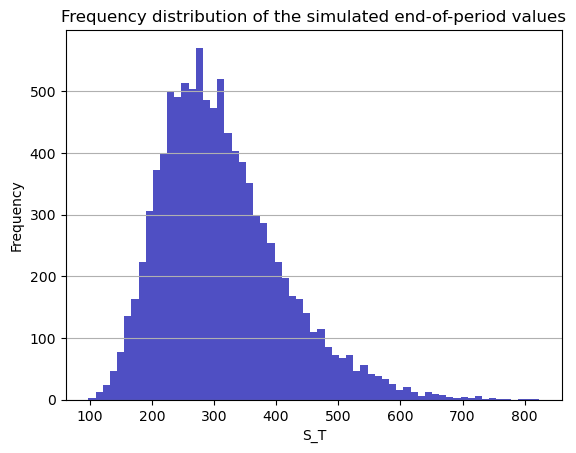

In [24]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=1)

plt.grid(axis='y')
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

In [25]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(c.round(4)))

European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $26.2217.


In [26]:
c = np.mean(np.maximum(K - S[:,-1],0))
print('European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(c.round(4)))

European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $58.4536.


### 2.3 Black-Scholes Model

In [27]:
S0 = 310.84       # spot stock price
K = 345           # strike
T = 1/4           # maturity (3 months)
r = 0.0353        # risk free rate
sig = vol.round(4)# volatility

In [28]:
def N(d):
    return si.norm.cdf(d, 0.0, 1.0)

In [29]:
def european_call_option_black_scholes_model(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    #d2 = d1 - vol * np.sqrt(T)
    
    if payoff == 'call':
        option_value = S * N(d1) - K * np.exp(-r * T) * N(d2)
    elif payoff == 'put':
        option_value =  - S * N(-d1) + K * np.exp(-r * T) * N(-d2)
    
    return option_value

In [30]:
V_bsm_c = european_call_option_black_scholes_model(S0, K, T, r, sig, 'call')
print('European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(V_bsm_c.round(4)))

European call with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $26.2091.


In [31]:
V_bsm_p = european_call_option_black_scholes_model(S0, K, T, r, sig, 'put')
print('European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is ${}.'.format(V_bsm_p.round(4)))

European put with spot share price of $310.84, a strike price of $345, a maturity of 3 months, a risk-free rate of 3.53% and a volatility of 61.50% is $57.3378.


In [32]:
S_ = np.linspace(175,475,33)
cp = np.zeros((len(S_),1))
for i in range(len(S_)):
    cp[i] = european_call_option_black_scholes_model(S_[i], K, T, r, sig, 'call')

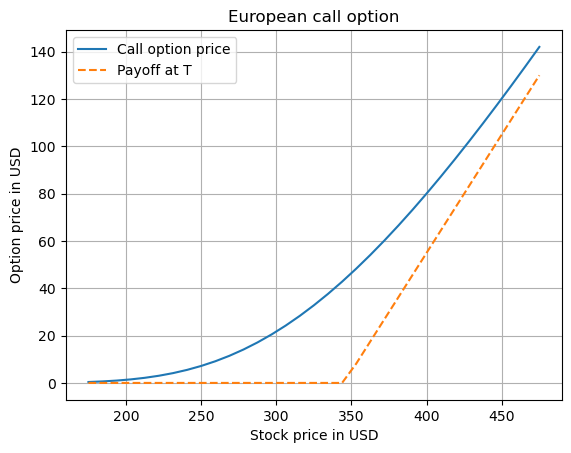

In [33]:
fig = plt.figure()
plt.plot(S_, cp, '-')
plt.plot(S_, np.maximum(S_-K, 0), '--')
plt.xlabel('Stock price in USD')
plt.ylabel('Option price in USD')
plt.grid()
plt.title('European call option')
plt.legend(['Call option price','Payoff at T'])

In [34]:
S_ = np.linspace(175,525,50)
Call = np.zeros((len(S_),1))
Put = np.zeros((len(S_),1))
for i in range(len(S_)):
    Call [i] = european_call_option_black_scholes_model(S_[i], K, T, r, sig, 'call')
    Put [i] = european_call_option_black_scholes_model(S_[i], K, T, r, sig, 'put')

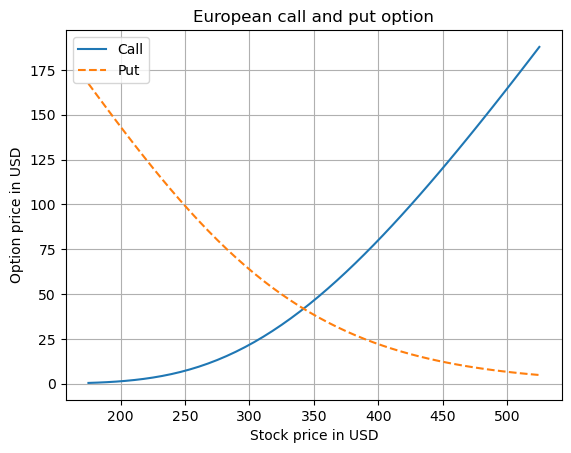

In [35]:
fig = plt.figure()
plt.plot(S_, Call, '-')
plt.plot(S_, Put, '--')
plt.grid()
plt.xlabel('Stock price in USD')
plt.ylabel('Option price in USD')
plt.title('European call and put option')
plt.legend(['Call','Put'])

### 2.4 Mibian

Using the `BS()` function of the `mibian` module (https://pypi.org/project/mibian), we can calculate the call and put price for european options using the Black-Scholes model.

In [36]:
S0 = 310.84       # spot stock price
K = 345           # strike
T = 1/4           # maturity (3 months)
r = 0.0353        # risk free rate
sig = vol.round(4)# volatility

In [37]:
option = mb.BS([S0, K, r*100, 365*T], volatility = sig*100)

In [38]:
print('The price of a European call option with a spot price of ${}, a strike price of ${}, a maturity of {} months, a volatility of {}% and a risk-free rate of {}%, calculated using the mibian module, is ${:.4f}.'.format(S0, K, int(T*12), sig*100, r*100, option.callPrice))

The price of a European call option with a spot price of $310.84, a strike price of $345, a maturity of 3 months, a volatility of 61.5% and a risk-free rate of 3.53%, calculated using the mibian module, is $26.2091.


In [39]:
print('The price of a European put option with a spot price of ${}, a strike price of ${}, a maturity of {} months, a volatility of {}% and a risk-free rate of {}%, calculated using the mibian module, is ${:.4f}.'.format(S0, K, int(T*12), sig*100, r*100, option.putPrice))

The price of a European put option with a spot price of $310.84, a strike price of $345, a maturity of 3 months, a volatility of 61.5% and a risk-free rate of 3.53%, calculated using the mibian module, is $57.3378.


The results show a similar price for both call and put options that our own implementation of the Back-Scholes model in Chapter 2.3.

***
## 3. Greeks

In [40]:
S0 = 310.84       # spot stock price
K = 345           # strike
T = 1/4           # maturity (3 months)
r = 0.0353        # risk free rate
sig = vol.round(4)# volatility

### 3.1 Delta

In [41]:
def delta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if payoff == 'call':
        delta = N(d1)
    elif payoff == 'put':
        delta = - N(-d1)

    return delta

In [42]:
delta(S0, K, T, r, sig, 'call')

0.43776918148121846

In [43]:
delta(S0, K, T, r, sig, 'put')

-0.5622308185187815

If the underlying asset increases by \\$1, from \\$310.84 to \\$311.84, the call/put option price will increase/decrease by \\$0.4378/\\$0.5622.

In [44]:
delta_S = np.linspace(150,600,50)
Delta_Call = np.zeros((len(delta_S),1))
Delta_Put = np.zeros((len(delta_S),1))
for i in range(len(delta_S)):
    Delta_Call[i] = delta(delta_S[i], K, T, r, sig, 'call')
    Delta_Put[i] = delta(delta_S[i], K, T, r, sig, 'put')

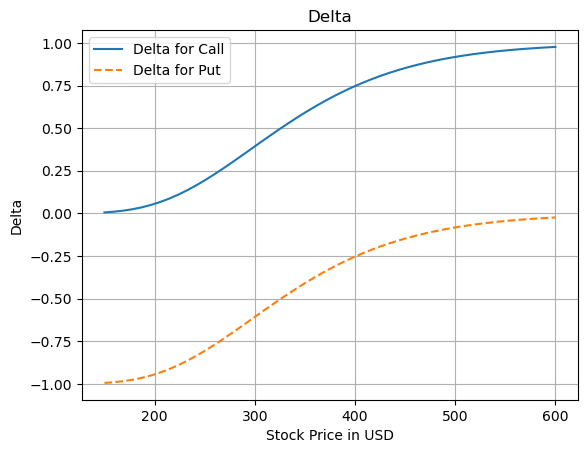

In [45]:
fig = plt.figure()
plt.plot(delta_S, Delta_Call, '-')
plt.plot(delta_S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price in USD')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [46]:
delta_S = np.linspace(50,600,50)
delta_T = np.linspace(0.25, 2, 51)
Delta = np.zeros((len(delta_T),len(delta_S)))
for j in range(len(delta_S)):
    for i in range(len(delta_T)):
        Delta[i,j] = delta(delta_S[j], K, delta_T[i], r, sig, 'call')

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/1347361090.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


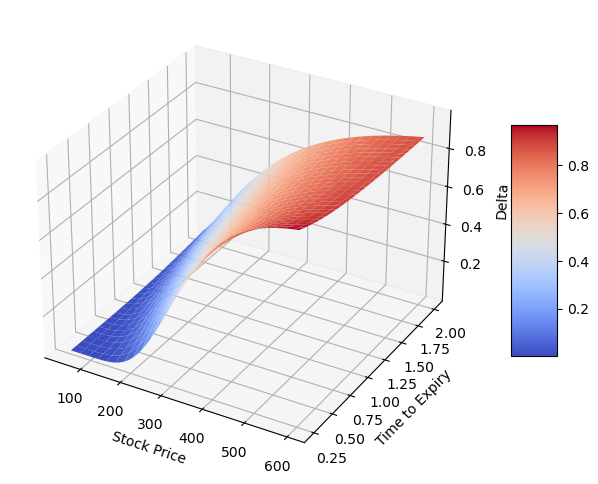

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
delta_S, delta_T = np.meshgrid(delta_S, delta_T)
surf = ax.plot_surface(delta_S, delta_T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

### 3.2 Gamma

In [48]:
def gamma(S, K, T, r, vol):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [49]:
gamma(S0, K, T, r, sig)

0.004122882387375171

If the underlying asset increases by \\$1, from \\$310.84 to \\$311.84, the Delta will increase by 0.0041.

In [50]:
gamma_S = np.linspace(150,600,50)
Gamma = np.zeros((len(gamma_S),1))
for i in range(len(gamma_S)):
    Gamma[i] = gamma(gamma_S[i], K, T, r, sig)

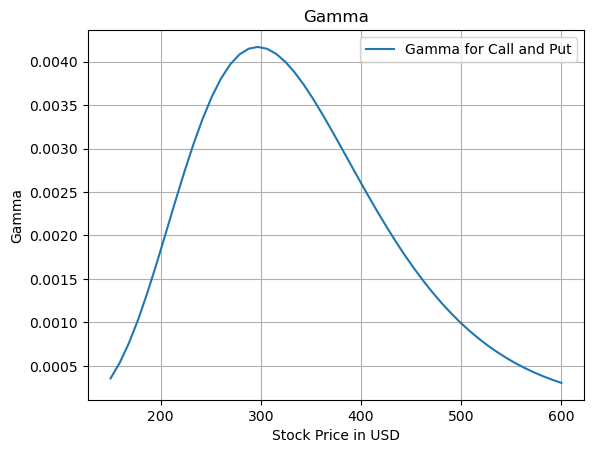

In [51]:
fig = plt.figure()
plt.plot(gamma_S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price in USD')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [52]:
gamma_S = np.linspace(50,600,50)
gamma_T = np.linspace(0.25, 2, 51)
Gamma = np.zeros((len(gamma_T),len(gamma_S)))
for j in range(len(gamma_S)):
    for i in range(len(gamma_T)):
        Gamma[i,j] = gamma(gamma_S[j], K, gamma_T[i], r, sig)

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/4218486476.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


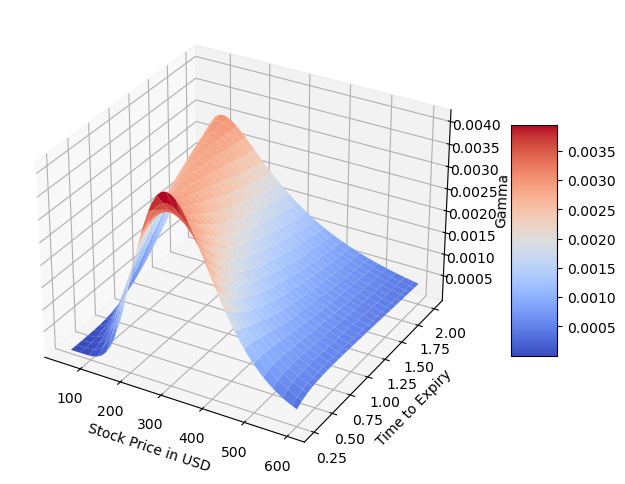

In [53]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
gamma_S, gamma_T = np.meshgrid(gamma_S, gamma_T)
surf = ax.plot_surface(gamma_S, gamma_T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price in USD')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

### 3.3 Speed

In [54]:
def speed(S, K, T, r, vol):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    speed = - si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [55]:
speed(S0, K, T, r, sig)

-3.253859366081168e-06

In [56]:
speed_S = np.linspace(150,600,50)
Speed = np.zeros((len(speed_S),1))
for i in range(len(speed_S)):
    Speed [i] = speed(speed_S[i], K, T, r, sig)

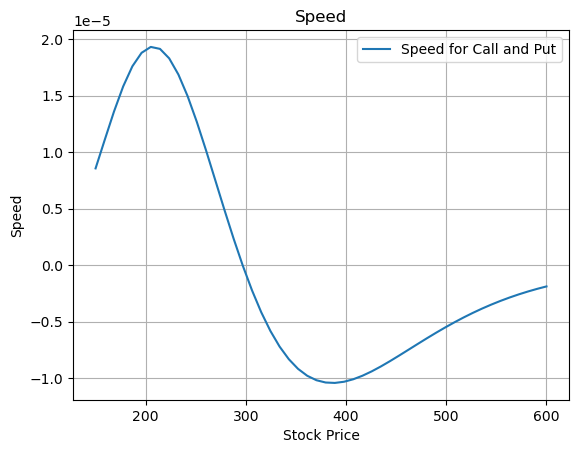

In [57]:
fig = plt.figure()
plt.plot(speed_S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

In [58]:
speed_S = np.linspace(125,500,50)
speed_T = np.linspace(0.25, 2, 51)
Speed = np.zeros((len(speed_T),len(speed_S)))
for j in range(len(speed_S)):
    for i in range(len(speed_T)):
        Speed[i,j] = speed(speed_S[j], K, speed_T[i], r, sig)

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/2809600343.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


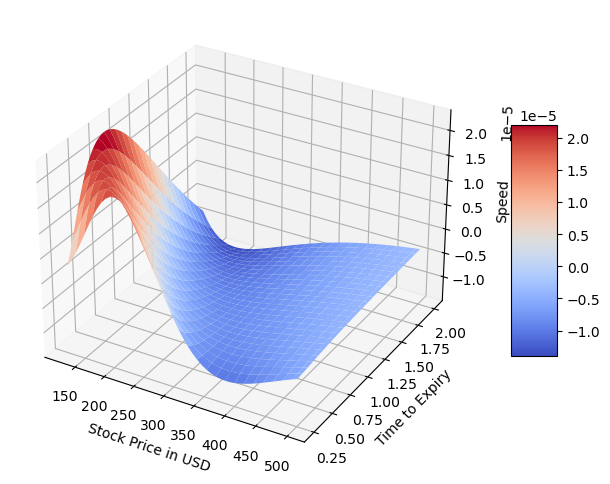

In [59]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
speed_S, speed_T = np.meshgrid(speed_S, speed_T)
surf = ax.plot_surface(speed_S, speed_T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price in USD')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

### 3.4 Theta

In [60]:
def theta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if payoff == 'call':
        theta = vol * S * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * N(d2)
    elif payoff == 'put':
        theta = vol * S * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N(-d2)
    
    return theta

In [61]:
theta(S0, K, T, r, sig, 'call')

79.2129946524417

In [62]:
theta(S0, K, T, r, sig, 'put')

67.14149707231363

If one day passes, with all other factors remaining constant, the call/put option price will decrease by \\$79.213/\\$67.1415.

In [63]:
theta_T = np.linspace(0.25,3,30)
Theta_Call = np.zeros((len(theta_T),1))
Theta_Put = np.zeros((len(theta_T),1))
for i in range(len(theta_T)):
    Theta_Call[i] = theta(S0, K, theta_T[i], r, sig, 'call')
    Theta_Put[i] = theta(S0, K, theta_T[i], r, sig, 'put')

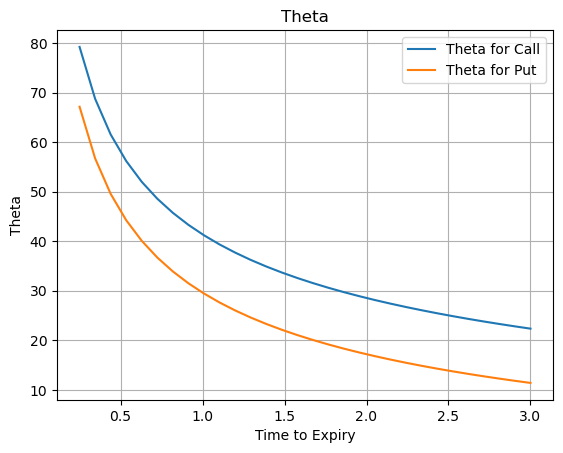

In [64]:
fig = plt.figure()
plt.plot(theta_T, Theta_Call, '-')
plt.plot(theta_T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

In [65]:
theta_S = np.linspace(50, 700,50)
theta_T = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(theta_T),len(theta_S)))
for j in range(len(theta_S)):
    for i in range(len(theta_T)):
        Theta[i,j] = theta(theta_S[j], K, theta_T[i], r, sig, 'call')

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/7638016.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


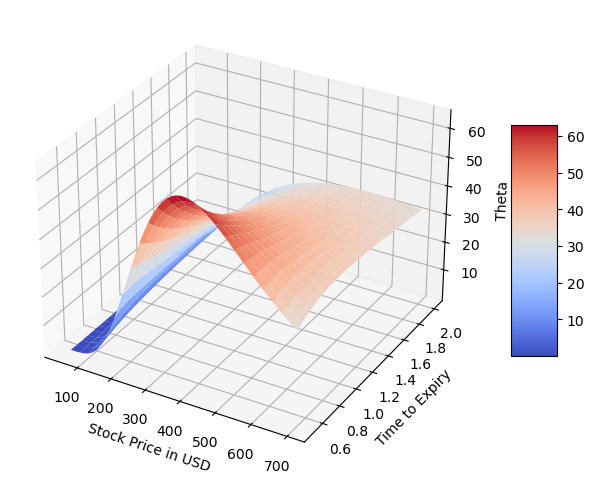

In [66]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
theta_S, theta_T = np.meshgrid(theta_S, theta_T)
surf = ax.plot_surface(theta_S, theta_T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price in USD')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

### 3.5 Rho

In [67]:
def rho(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if payoff == 'call':
        rho = K * T * np.exp(-r * T) * N(d2)
    elif payoff == 'put':
        rho = - K * T * np.exp(-r * T) * N(-d2)
    
    return rho

In [68]:
rho(S0, K, T, r, sig, 'call')

27.466775196702944

In [69]:
rho(S0, K, T, r, sig, 'put')

-58.025417297121855

If the interest rate increases by 1% the call/put option price is expected to increase/decrease by \\$27.4668/\\$58.0254.

In [70]:
rho_r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(rho_r),1))
Rho_Put = np.zeros((len(rho_r),1))
for i in range(len(rho_r)):
    Rho_Call [i] = rho(S0, K, T, rho_r[i], sig, 'call')
    Rho_Put [i] = rho(S0, K, T, rho_r[i], sig, 'put')

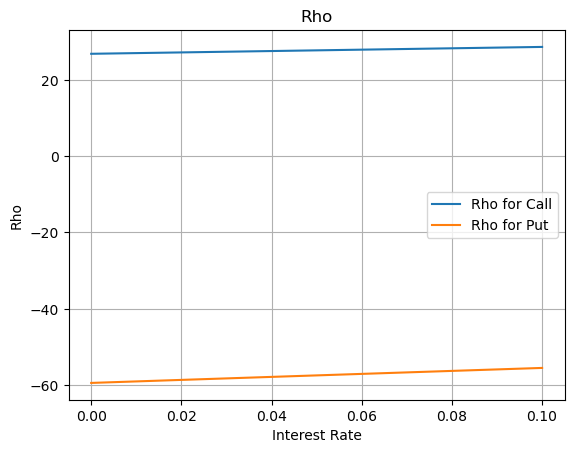

In [71]:
fig = plt.figure()
plt.plot(rho_r, Rho_Call, '-')
plt.plot(rho_r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [72]:
rho_S = np.linspace(150,600,50)
rho_T = np.linspace(0.25, 2, 51)
Rho = np.zeros((len(rho_T),len(rho_S)))
for j in range(len(rho_S)):
    for i in range(len(rho_T)):
        Rho[i,j] = rho(rho_S[j], K, rho_T[i], r, sig, 'call')

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/3683648061.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


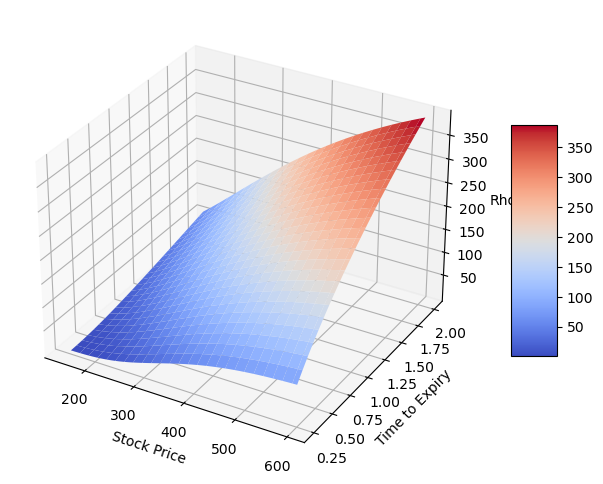

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
rho_S, rho_T = np.meshgrid(rho_S, rho_T)
surf = ax.plot_surface(rho_S, rho_T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

### 3.6 Vega

In [74]:
def vega(S, K, T, r, vol):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [75]:
vega(S0, K, T, r, sig)

61.24771219078637

If the volatility of the underlying asset increases by 1%, the option's price is expected to increase by \\$61.2477 for both the call and the put, all else being equal.

In [76]:
volatility = np.linspace(0.25,3,50)
Vega = np.zeros((len(volatility),1))
for i in range(len(volatility)):
    Vega [i] = vega(S0, K, T, r, volatility[i])

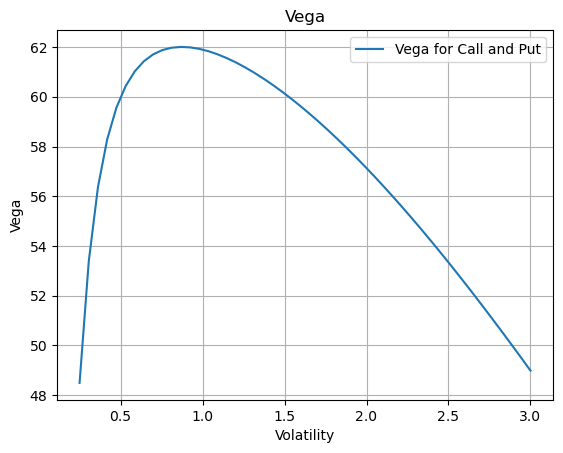

In [77]:
fig = plt.figure()
plt.plot(volatility, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [78]:
vega_S = np.linspace(150,600,50)
vega_T = np.linspace(0.25, 2, 51)
Vega = np.zeros((len(vega_T),len(vega_S)))
for j in range(len(vega_S)):
    for i in range(len(vega_T)):
        Vega[i,j] = vega(vega_S[j], K, vega_T[i], r, sig)

/var/folders/vt/q4zlzd7d1d3cb_0tdbtryz780000gn/T/ipykernel_71163/1086336500.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


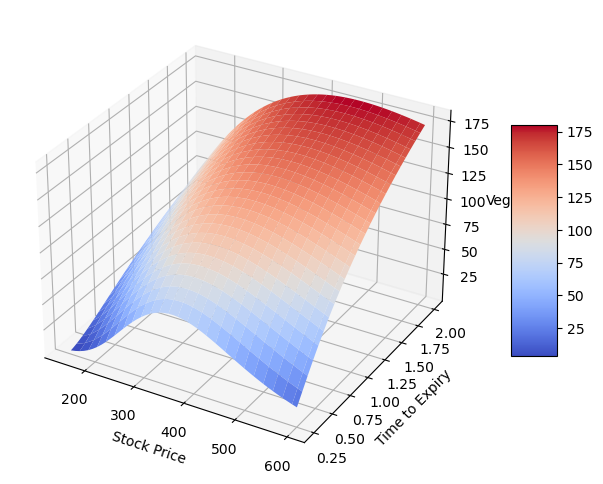

In [79]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
vega_S, vega_T = np.meshgrid(vega_S, vega_T)
surf = ax.plot_surface(vega_S, vega_T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);